# Cumulant LBM

Setup almost as in Tutorial - only x direction is not periodic any more


In [1]:
from waLBerla import *
from material.matplotlib_setup import *
import waLBerla.plot as wplt

blocks = createUniformBlockGrid( cells=(100,100,1), periodic=(0,0,1) )

omega = 1.9
collisionModel =lbm.collisionModels.SRT( omega )
forceModel = lbm.forceModels.SimpleConstant( (0,0,0) )
latticeModel = lbm.makeLatticeModel( "D2Q9", collisionModel, forceModel, compressible=True )
lbm.addPdfFieldToStorage( blocks, "pdfs", latticeModel, velocityAdaptor="vel", densityAdaptor="rho", initialDensity=1.0 )

Here is the important change: even if we you do not really make use of the lattice models here since you use custom collide - the lattice model is used to setup the pdf field. There are two modes: 
- compressible, pdfs are centered around 1
- incompressible, pdfs are centered around 0 for better numeric accuracy

Yes, the terminology is totally misleading :) 

However, here the simple solution is to just use "compressible=True"

In the next cell you can check the density:

In [2]:
from getCollide import getDensity

# Get the density manually
def  printDensity(blocks):
    pdfField = field.toArray( blocks[0]['pdfs'] )
    density=getDensity( pdfField, 0,0 )
    #print(density)
    
# you can also C++ adaptor for this
def printDensityAdaptor( blocks ):
    rho = field.toArray( blocks[0]['rho'] ).squeeze()
    #print( rho )

    
# same with velocity
def printVelAdaptor( blocks ):
    print( field.toArray( blocks[0]['vel'])[:,:,:,:1].squeeze() )

    
printDensity(blocks)
printDensityAdaptor( blocks )

In [3]:
field.addFlagFieldToStorage( blocks, 'flags' )
lbm.addBoundaryHandlingToStorage( blocks, 'boundary', 'pdfs', 'flags' )
sweep = lbm.makeCellwiseSweep( blocks, "pdfs", flagFieldID='flags', flagList=['fluid'] )

Here I also made a change: the channel is now driven by pressure boundaries instead of a body force.

In [4]:
import inspect
def setBoundariesChannel( blocks, boundaryHandlingID ):
    for block in blocks:
        b = block[ boundaryHandlingID ]        
        if block.atDomainMinBorder[0]:
            b.forceBoundary( 'NoSlip',   makeSlice[ 0, :, :, 'g'] )
        if block.atDomainMaxBorder[0]:
            b.forceBoundary( 'NoSlip',   makeSlice[ -1, :, :, 'g'] )        
        if block.atDomainMinBorder[1]:
            b.forceBoundary( "UBB", makeSlice[ :, -1, :, 'g'], { 'x': 0.04} )
        if block.atDomainMaxBorder[1]:
            b.forceBoundary( 'NoSlip',   makeSlice[ :,0, :, 'g'] )
        b.fillWithDomain()
setBoundariesChannel( blocks, 'boundary' )

In [5]:
communication = createUniformBufferedScheme( blocks, 'D2Q9')
communication.addDataToCommunicate( field.createPackInfo( blocks, 'pdfs') )

Use your collision operation instead of the waLBerla one

In [6]:
from getCollide import getCollide

collide = getCollide(omega)

def run( timesteps ):
    for t in range(timesteps):
        communication()
        for block in blocks: block['boundary']()
        for block in blocks: sweep.stream( block )
        for block in blocks: collide(block)
        #for block in blocks: sweep.collide(block)

In [ ]:
def setByMask( blocks, targetField, targetValue, flagField, flagNames ):
    for b in blocks:
        mask = 0
        for flagName in flagNames:
            mask |= b[flagField].flag(flagName)

        targetArr = field.toArray( b[targetField], True )
        flagArr   = field.toArray( b[flagField]  , True )[:,:,:,0]
        targetArr[ np.bitwise_and( flagArr, mask ) > 0, : ] = targetValue


def visualizationStep():
    run(10)
    # Set pdfs to NaN in NoSlip cells:
    setFieldUsingFlagMask(blocks, 'pdfs', np.NaN, 'flags', ['NoSlip'] )

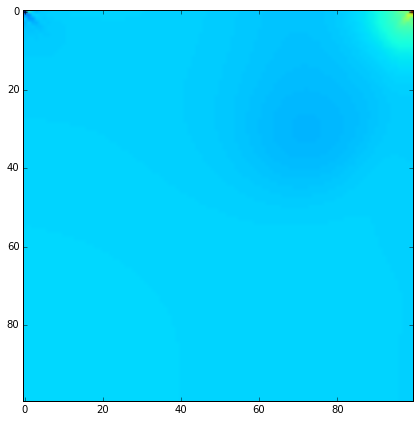

In [ ]:
from IPython import display
run( 8000 )
for i in range(1000):
    run( 100)
    wplt.scalarField( blocks, 'rho', makeSlice[:,:,0.5] )
    display.display( wplt.gcf() )
    display.clear_output(wait=True)

The density field is unfortunately not symmetric - probably a bug in your collision.
I suspect that the reason is the mapping of fourth coordinate to direction.

The mapping for D2Q9 is: (north-south is y coordinate, east-west is x coordinate)

In [ ]:
D2Q9 = { stencil.Direction.C : 0,
         stencil.Direction.N : 1,
         stencil.Direction.S : 2,
         stencil.Direction.W : 3,
         stencil.Direction.E : 4,
         stencil.Direction.NW :5,
         stencil.Direction.NE: 6,
         stencil.Direction.SW :7,
         stencil.Direction.SE :8,}